\begin{equation*}
\newcommand{\E}{\mathbb{E}}
\newcommand{\Nor}{\mathcal{N}}
\end{equation*}




# Due Dates

* Textbook: None, due to the shortened week
* Coding: Tuesday, November 20, at 11:59 PM

# Textbook Problems

* 4.5
* 4.10
* 4.12




In [1]:
# This is code to load the assignment.
# You'll need to run this code do or restart the assignment.
from loadAssignment import loadAssignment
Assignment, Questions, Submit, Data = loadAssignment(8)

# These are modules that we need
# once you run this code, you don't need to load them again
import autograd.numpy as np
import autograd as ag
import scipy.linalg as la
import scipy.signal as sp
import scipy.stats as st
import matplotlib.pyplot as plt
%matplotlib inline


Here is some code that may be helpful. 



In [2]:
# Helper functions 
def dot(*mats):
    """
    Computes product of arbitrary matrices
    """
    
    if len(mats) == 1:
        return mats[0]
    else:
        return np.dot(mats[0],dot(*mats[1:]))


def ricS(A,C,Q,R,S):
    """
    Solves the generalized riccati equation with correlation term, S:
    
    P = Q + APA' - (APC' + S)(CPC'+R)^{-1}(CPA'+S')
    """
    AC = A-np.dot(S,la.solve(R,C))
    QC = Q - np.dot(S,la.solve(R,S.T))
    QC = .5 * (QC + QC.T)
    P = la.solve_discrete_are(AC.T,C.T,QC,R)
    return P

def observabilityMatrix(A,C):
    """
    Compute the observability matrix:
    [C,
     CA,
     :,
     CA^{n-1}]
    """
    
    n = len(A)
    ObsList = []
    Mat = np.copy(C)
    for _ in range(n):
        ObsList.append(Mat)
        Mat = np.dot(C,A)
    return np.vstack(ObsList)




# Question 0





The first few problems revisit the system
\begin{align*}
x_{k+1} &= \Phi x_k + w_k \\
y_k &= H x_k + v_k
\end{align*}

where the matrices are given by:



In [3]:
Phi = np.array([[0.5, -0.5],
[0.5, 0.5]])
H = np.array([[1, 0]])


A whole bunch of measurements are given here. 



In [4]:
Y = Data.Y


Here each row is a value of $y_k$. The format is slightly different from last time. It is an $N\times 1$ array, whereas the last time, it 
was just a flat length $N$ array.

In the last assignment, we constructed an estimator based on nominal models for $Q$ and $R$. The estimator had the form

\begin{align*}
\hat x_{k+1} &= \Phi \hat x_k + L_{nom}(y_k-H\hat x_k) \\
\hat y_k &= H \hat x_k
\end{align*}

It was shown that $L_{nom}$ was unlikely to be optimal based 
analysis of residuals.
The analysis is repeated here, in shortened form.



In [5]:
# Code from last time
    
# This is the nominal model
Q_nom = np.eye(2)
R_nom = np.eye(1)
P_nom = la.solve_discrete_are(Phi.T,H.T,Q_nom,R_nom)
Psi_nom = dot(H,P_nom,H.T) + R_nom
L_nom = la.solve(Psi_nom,dot(H,P_nom,Phi.T)).T


# Predictions from nominal model
PredNom = (Phi-np.dot(L_nom,H),L_nom,H,np.zeros((1,1)),-1)
_,Y_nom,_ = sp.dlsim(PredNom,Y)



# This is code for testing it

# Let's do  the least-squares predictor to estimate
# The optimal residual covariance
p = 10

Y_s = Y.squeeze()

Hank = la.hankel(Y_s[:p+1],Y_s[p:])

G = la.lstsq(Hank[:-1].T,Hank[-1])[0]

Y_LS = np.dot(G,Hank[:-1])
Res_LS = Y_s[p:] - Y_LS
Psi_LS = np.mean(Res_LS**2)

# Now we compare the emperical residual to the predicted optimal
# Residual
Res = Y-Y_nom

Psi_emp = np.mean(Res**2).squeeze()

NumSteps = len(Y)
CDF = st.chi2.cdf(NumSteps * Psi_emp / Psi_LS,df=NumSteps)

print('Based on chi-squared statistic, our residual is in the %gth percentile' % (CDF*100,))

Based on chi-squared statistic, our residual is in the 100th percentile



In the next few questions, we will step through the residual whitening method. We will use a slightly simpler algorithm than suggested by the book. In most cases, they give similar results.

Now we review the residual whitening algorithm.

The residual errors are given by $e_k = y_k-\hat y_k$. The residual correlations are given by:

\begin{equation*}
C_i = \mathbb{E}[e_{k+i} e_k^\top ]
\end{equation*}



Let $\tilde \Phi = \Phi - L_{nom} H$.
If the system has $n$ states, then
\begin{equation*}
\begin{bmatrix}
C_1 \\
C_2 \\
\vdots \\
C_n
\end{bmatrix} = \begin{bmatrix}
H \\
H\tilde \Phi \\
\vdots \\
H\tilde \Phi^{n-1}
\end{bmatrix} (\Omega - L_{nom}C_0),
\end{equation*}
where $\Omega = \Phi P H^\top$, and $P$ is the nominal filter error covariance, $\mathbb{E}[(x_k-\hat x_k)(x_k-\hat x_k)^\top]$.

The filter error covariance satisfies:

\begin{align*}
P &= Q + L_{nom}RL_{nom}^\top + (\Phi-L_{nom}H)P(\Phi-L_{nom} H)^\top \\
&= Q-\tilde Q + \Phi P \Phi^\top
\end{align*}
where $\tilde Q = L_{nom}\Omega^\top + \Omega L_{nom}^\top - L_{nom} C_0 L_{nom}^\top$.

The optimal filter error covariance is given by $P^*$, which satisfies:
\begin{equation*}
P^* = Q + \Phi P^* \Phi^\top - \Phi P^* H^\top (HP^*H^\top +R)^{-1} H P^* \Phi^\top.
\end{equation*}

Setting $P^* = P + \delta P$ and subtracting the equation for $P$ gives that
\begin{equation*}
\delta P = \tilde Q + \Phi \delta P \Phi^\top - (\Phi \delta P H^\top + \Omega)(H\delta P H^\top + C_0)^{-1} 
(\Phi \delta P H^\top + \Omega)^\top
\end{equation*}

Finally, the optimal gain is given by:
\begin{equation*}
L^* = (\Phi \delta P H^\top + \Omega) (H\delta P H^\top + C_0)^{-1}
\end{equation*}

The residual whitening algorithm goes through the following steps.

* Estimate $C_i$ using empirical means.
* Solve for $\Omega$.
* Solve for $\delta P$
* solve for $L^*$.

For this question, estimate $C_0,C_1,C_2$ by empirical means. Store your results in a $3x1x1$ array called `C_arr`. 
(The funny shape is for compatibility with other tests. You can think about it as a list of $1\times 1$ matrices for each of the covariances.)



In [6]:
def residualCorrelations(Res,N):
    C_list = []
    NumSteps = len(Res)
    for i in range(N):
        if i > 0:
            C = np.dot(Res[i:].T,Res[:-i]) / (NumSteps-i)
        else:
            C = np.dot(Res.T,Res)/NumSteps
        C_list.append(C)
    
    C_arr = np.array(C_list)
    
    return C_arr

Res = Y - Y_nom
n = 2
C_arr = residualCorrelations(Res,n+1)

Questions[0].checkAnswer(C_arr)

You estimated residual correlations:
[[[ 3.91418888]]

 [[-0.4830188 ]]

 [[-0.57974419]]]
For reference, the optimal correlations are:
[[[3.61593681]]

 [[0.        ]]

 [[0.        ]]]
Note that since L was suboptimal, the correlations will not match well.
Oh yeah!
A score of 1 was entered for Question 0



# Question 1

Now compute the optimal gain and call it `L`. The commands `observabilityMatrix` will be helpful for the obserbability matrix term, and `ricS` is helpful for the Riccati equation for $\delta P$.




In [7]:
PhiL,L,H,D,dt = PredNom    
Obs = observabilityMatrix(PhiL,H)
Omega = dot(L,C_arr[0]) + la.lstsq(Obs,np.vstack(C_arr[1:]))[0]
dQ = np.dot(Omega,L.T)+np.dot(L,Omega.T) - dot(L,C_arr[0],L.T)
dP = ricS(Phi,H,dQ,C_arr[0],Omega)

Psi_update = C_arr[0] + dot(H,dP,H.T)
L = la.solve(Psi_update,Omega.T+dot(H,dP,Phi.T)).T


Questions[1].checkAnswer(L)

Your udpated gain is now
[[0.16729533]
 [0.55883007]]
The true optimal gain is
[[0.13749891]
 [0.58594759]]
The original nominal gain was
[[0.34600806]
 [0.26308318]]
Hoorah!
A score of 1 was entered for Question 1



# Question 2

The previous question should have gotten the gain closer to the true optimal value.

Now let's see if the algorithm lives up to its name. Construct an estimator using your new gain, $L$. 
Estimate the residual correlations $C_0,C_1,C_2$. Store them in a $3\times 1 \times 1$ array called `C_update`.

If the residual has been whitened, the estimates of $C_1$ and $C_2$ should be smaller. (The they are zero when the true optimal estimator is used.)



In [8]:
Predictor = (Phi - np.dot(L,H),L,H,np.zeros((1,1)),-1)
_,Y_pred,_ = sp.dlsim(Predictor,Y)
C_update = residualCorrelations(Y-Y_pred,n+1)

Questions[2].checkAnswer(C_update)

You estimated residual correlations:
[[[ 3.63430535]]

 [[-0.02743486]]

 [[-0.02852754]]]
For reference, the optimal correlations are:
[[[3.61593681]]

 [[0.        ]]

 [[0.        ]]]
Huzzah.
A score of 1 was entered for Question 2



Also, the hypothesis test should now fall comfortably within the 95 percent confidence interval.



In [9]:
# Now let's do the hypothesis test.

Psi_update = C_update[0,0,0]
CDF = st.chi2.cdf(NumSteps * Psi_update / Psi_LS,df=NumSteps)
print('Now the chi-squared statistic is in %gth percentile' % (100*CDF,))

Now the chi-squared statistic is in 52.862th percentile



# Question 3

The rest of  the assignment will focus on the multiple-model adaptive estimation (MMAE) problem.

We study a model with two sensors and two actuators. We use the MMAE framework to estimate the likelihood of a sensor or actuator failing.

The models ahave the form:

\begin{align*}
x_{k+1} &= \Phi x_k + \Gamma^j u_k + w_k \\
y_k & =H^i x_k + v_k,
\end{align*}

Each $H^i$ corresponds to a different measurement matrix, depending on which sensors are functioning. Similarly, each $\Gamma^j$ corresponds to a different input matrix, depending on which actuator are functioning.

For each of the models, the state matrix, $\Phi$ is the same, and the noises follow the same distributions $w_k\sim \mathcal{N}(0,Q)$ and $v_k \sim \mathcal{N}(0,R)$.

In all cases, we will assume that $x_0 = 0$, so that $\hat x_0^{(i,j),-} = 0$ and $P_0^{(i,j),-} = 0$. 

The models are given below:



In [10]:
Phi_M = np.array([[1, 0.1, 0, 0],
[-0.1, 0.9, 0.1, 0],
[0, 0, 1, 0.1],
[0.1, 0, -0.1, 0.9]])

Q_M = np.array([[0, 0, 0, 0],
[0, 0.25, 0, 0],
[0, 0, 0, 0],
[0, 0, 0, 0.25]])

R_M = np.array([[1, 0],
[0, 1]])

H_M_list = Data.H_M_list
Gam_M_list = Data.Gam_M_list
print(H_M_list)
print(Gam_M_list)

[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[1. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 1. 0.]]

 [[1. 0. 0. 0.]
  [0. 0. 1. 0.]]]
[[[0.  0. ]
  [0.  0. ]
  [0.  0. ]
  [0.  0. ]]

 [[0.  0. ]
  [0.1 0. ]
  [0.  0. ]
  [0.  0. ]]

 [[0.  0. ]
  [0.  0. ]
  [0.  0. ]
  [0.  0.1]]

 [[0.  0. ]
  [0.1 0. ]
  [0.  0. ]
  [0.  0.1]]]



Since there are $4$ different measurement matrices and $4$ different input matrices, there are a total of $4\times 4 = 16$ different models.

We start with a prior over models $p(m=(i,j)) = 1/16$. In other words, we assume initially that each sensor/actuator combination is equally likely. Then let $W_k^{(i,j)} = p(m=(i,j)| y_{0:k})$. (The input will be deterministic, and thus it is not required in the conditioning.)

From the theory discussed in class, the weights can be updated as:

\begin{align*}
\tilde W_{k}^{(i,j)} & = p(y_{k} | m=(i,j), y_{0:k-1}) W_{k-1}^{(i,j)}  \\
W_{k}^{(i,j)} &= \frac{\tilde W_k^{(i,j)}}{\sum_{i',j'=0}^3 \tilde W_{k}^{(i',j')}}
\end{align*}

For initialization, we take $W_{-1}^{(i,j)} =1/16$, and $p(y_0|m=(i,j),y_{0:-1})=p(y_0|m=(i,j))$.

The inputs and the measurements are given below:



Text(0.5, 0, 'Time')

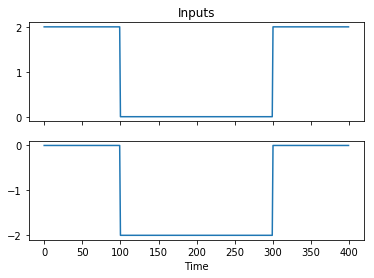

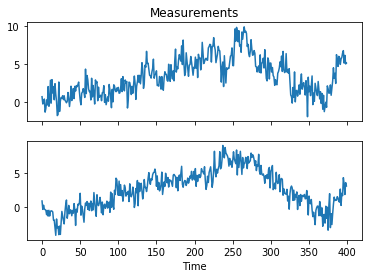

In [11]:
Y_M = Data.Y_M
U_M = Data.U_M

fig,ax = plt.subplots(2,1,sharex=True)
Time = np.arange(len(Y_M))
ax[0].set_title('Inputs')
ax[0].plot(Time,U_M[:,0])
ax[1].plot(Time,U_M[:,1])
ax[1].set_xlabel('Time')

fig,ax = plt.subplots(2,1,sharex=True)
ax[0].set_title('Measurements')
ax[0].plot(Time,Y_M[:,0])
ax[1].plot(Time,Y_M[:,1])
ax[1].set_xlabel('Time')


Compute the sequence of weights $W_k^{(i,j)}$, where $k$ is the time index, $i$ corresponds to the index of the measurement matrix and $j$ corresponds to the index of the input matrix. Store them in an $N\times 4\times 4$ array called `W_arr`.



Here is a plot of your weights
The weights of the true model are shown in bold blue
The rest are in red
Hoorah!
A score of 1 was entered for Question 3


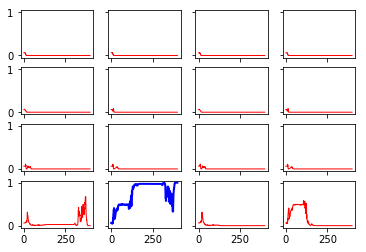

In [12]:
N = len(Y_M)
NumB = len(Gam_M_list)
NumC = len(H_M_list)
TotModes = NumB * NumC

Weights = np.ones((NumC,NumB)) / TotModes

n = 4

P_arr = np.zeros((NumC,NumB,n,n))
Mu_arr = np.zeros((NumC,NumB,n)) 

W_arr =np.zeros((N,NumC,NumB))

A = Phi_M

for k in range(N):
    W_pre = np.zeros((NumC,NumB))
    y = Y_M[k]
    u = U_M[k]
    for i in range(NumC):
        C = H_M_list[i]
        for j in range(NumB):
            B = Gam_M_list[j]
            mu = Mu_arr[i,j]
            P = P_arr[i,j]

            Psi = dot(C,P,C.T) + R_M
            
            likelihood = st.multivariate_normal.pdf(y,mean=np.dot(C,mu),cov=Psi)
            W_pre[i,j] = likelihood * Weights[i,j]
            
            K = la.solve(Psi,dot(C,P,A.T)).T
            mu_next = np.dot(A,mu) + np.dot(K,y-np.dot(C,mu)) + np.dot(B,u)
            P_next = Q_M + dot(A,P,A.T) - dot(K,Psi,K.T)
            P_next = .5 * (P_next + P_next.T)
            
            Mu_arr[i,j] = mu_next
            P_arr[i,j] = P_next
            
            
    Weights = W_pre / np.sum(W_pre)
    W_arr[k] = Weights

Questions[3].checkAnswer(W_arr)


# Question 4

One of the measurement matrices gives the same weights no matter which input matrix is used. In other words, for each time $k$, we have
$W_k^{(i,0)} = W_k^{(i,1)}=W_k^{(i,2)}=W_k^{(i,3)}$. Which index $i$ is it? Think about why  this is true.



In [13]:
i = 0
Questions[4].checkAnswer(i)

Huzzah.
A score of 1 was entered for Question 4



# Final Score

You can run this code to see all of your scores.




In [14]:
Assignment.showResults()

Problem 0: 1
Problem 1: 1
Problem 2: 1
Problem 3: 1
Problem 4: 1

Total: 5 / 5





# Submission

Save your work and run this cell to submit. It will only work if you have the internet.

